# Cloud identification and the Radial Distribution Function

The aim of this notebook is to explore how to 
1. identify cloud objects from 2D fields and
2. quantify cloud clustering using the radial distribution function (RDF).

This is part of my research on convective variability, where cloud size distributions and clustering play important roles. Here we will test the sensitivity of the results to several parameters in the algorithms. 

The first step is to identify some example cases and categorize them visually. We will pick the following 6 examples from our dataset (COSMO model output with 2.8km grid spacing):
- a) 28 May 2016 15UTC
- b) 28 May 2016 20UTC
- c) 3 June 2016 13UTC
- d) 3 June 2016 21UTC
- e) 30 May 2016 6UTC
- f) 28 May 2016 9UTC

We will look at the hourly precipitation field for now. By changing `var` below from *prec* to *w*, you can also do the same analysis for the vertical velocity field at a specified level (default is level 30 = approx 2.4km agl). Let's now plot the fields.

#### Technical Note
In order for this notebook to run, ???

In [1]:
# Import modules and load fields
import sys
sys.path.append('../python_scripts')   # So that we can later use the functions from helpers.py
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from cosmo_utils.pyncdf import getfobj_ncdf   # This is a module developed specifically for COSMO output

# Pick 6 examples
alims = (50, -51, 50, -51)   # Limits for analysis area
dates = ['2016052800', '2016052800', '2016060300', 
         '2016060300', '2016053000', '2016052800']
times = [15, 20, 13, 21, 6, 9]
tags = ['a) Scattered', 'b) Clustered', 'c) Scattered', 
        'd) Clustered', 'e) Single large cloud', 'f) Hardly any clouds']

# Pick variable [prec or w]
var = 'prec'

# Plot the fields
fig, axmat = plt.subplots(2, 3, figsize = (13, 10))
cm = plt.cm.cool
cm.set_under(color = 'white')
field_list = []
example_field_url = 'https://github.com/raspstephan/convective_variability_analysis/raw/master/jupyter_notebooks/example_fields/'

for d, t, tag, ax in zip(dates, times, tags, np.ravel(axmat)):
    
    if var == 'prec':
        url = example_field_url + d + '_00' + str(t).zfill(2) + '0000_prec.npy'
        field = np.load(url)
        print field
        fn = ('/project/meteo/scratch-old/users/stephan.rasp/convective_variability_data/raw_data/' + 
              d + '/deout_ceu_pspens/det/OUTPUT/lfff00' + str(t).zfill(2) + '0000.nc_30m_surf')
        field = getfobj_ncdf(fn, 'PREC_ACCUM').data[alims[0]:alims[1], alims[2]:alims[3]]
    elif var == 'w':
        fn = ('/project/meteo/scratch-old/users/stephan.rasp/convective_variability_data/raw_data/' + 
              d + '/deout_ceu_pspens/det/OUTPUT/lfff00' + str(t).zfill(2) + '0000.nc_30m')
        field = getfobj_ncdf(fn, 'W').data[30, alims[0]:alims[1], alims[2]:alims[3]]   # At model level 30
    else: 
        raise Exception('Wrong variable!')
        
    field_list.append(field)
    im = ax.imshow(field, cmap=cm, origin='lower', vmin=1)
    plt.sca(ax)
    cb = fig.colorbar(im, shrink = 0.6, orientation='horizontal', pad=0.07)
    if var == 'prec':
        cb.set_label('Precipitation [mm/h]')
    else:
        cb.set_label('W [m/s]')
    ax.set_title(tag + ' ' + d + ' ' + str(t).zfill(2) + ' UTC')

plt.tight_layout()

ImportError: No module named netCDF4

Our human eyes have no problem detecting the different objects and structures. To compare the results of the RDF metric later against our intuition we will label the examples as follows:

- a) Scattered
- b) Clustered
- c) Scattered
- d) Clustered
- e) Single large cloud
- f) Hardly any clouds

## 1. Cloud Object Identification

Our first task is to find an algorithm that identifies the individual cloud objects. For this we use a four-connected pixel connectivity algorithm. This means that pixels which share a common edge are identified as one object. This is done inside the `helpers.identify_clouds` function. Inspiration on how to do this in Python comes from this great example: https://dragly.org/2013/03/25/working-with-percolation-clusters-in-python/

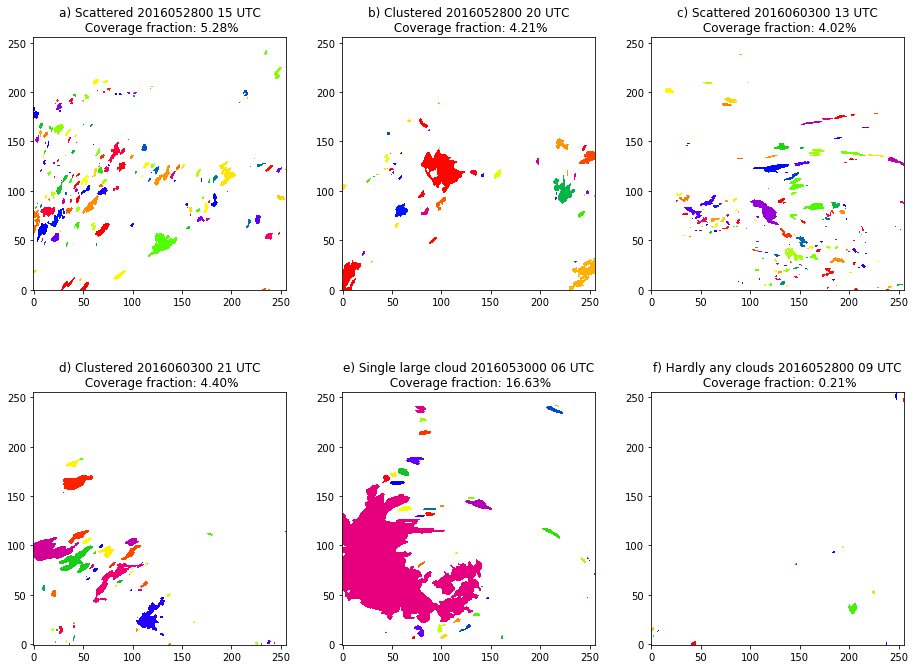

In [10]:
import helpers

threshold = 1.
labels_list = []
fig, axmat = plt.subplots(2, 3, figsize = (13, 10))
cm_prism = plt.cm.prism
cm_prism.set_under(color = 'white')
for field, d, t, tag, ax in zip(field_list, dates, times, tags, np.ravel(axmat)):
    cov_frac = np.sum(field > threshold) / np.float(field.size)
    labels = helpers.identify_clouds(field, threshold, water=False)[0]
    labels_list.append(labels)
    ax.imshow(labels, cmap=cm_prism, origin='lower', vmin = 1)
    ax.set_title(tag + ' ' + d + ' ' + str(t).zfill(2) + ' UTC' + 
                '\n Coverage fraction: {:.2f}%'.format(cov_frac * 100.))
plt.tight_layout()

Each identified "object" is now shown in a different color. One issue which is immediately noticeable, particularly in examples d) and e) is that some objects are rather large. Comparing these maps with the precipitation fields, we notice that some objects seem to be made up of many touching clouds. This can severely impact cloud statistics! Therefore, we will now explore how to further separate the objects into sub-objects.

### Cloud separation

One method to divide the identified objects is a *local maximum filter*. This algorithm searches for the local maxima in each object. These points are then used as a starting point for a *watershed algorithm*. Here sub-objects are found by going downgradient from the local maxima to the next local minima (actually, the algorithm is defined the other way round). For a more detailed explanation see for example: https://www.mathworks.com/company/newsletters/articles/the-watershed-transform-strategies-for-image-segmentation.html

One parameter for the local maxima search algorithm is the search footprint (`neighborhood` in `helpers.identify_clouds`). This is a 2D array which defines the extent of the search area for local maxima. The smaller the array, the closer the individual maxima can be toghether. So a very small perimeter gives many very small clouds. We will test the sensitivity to this parameter by chosing the following values:
- A cross defined by [[0,1,0],[1,1,1],[0,1,0]]
- A filled 3 by 3 matrix
- A filled 5 by 5 matrix
- A filled 11 by 11 matrix  

Note that for our data one grid point corresponds to approximately 2.8 km.

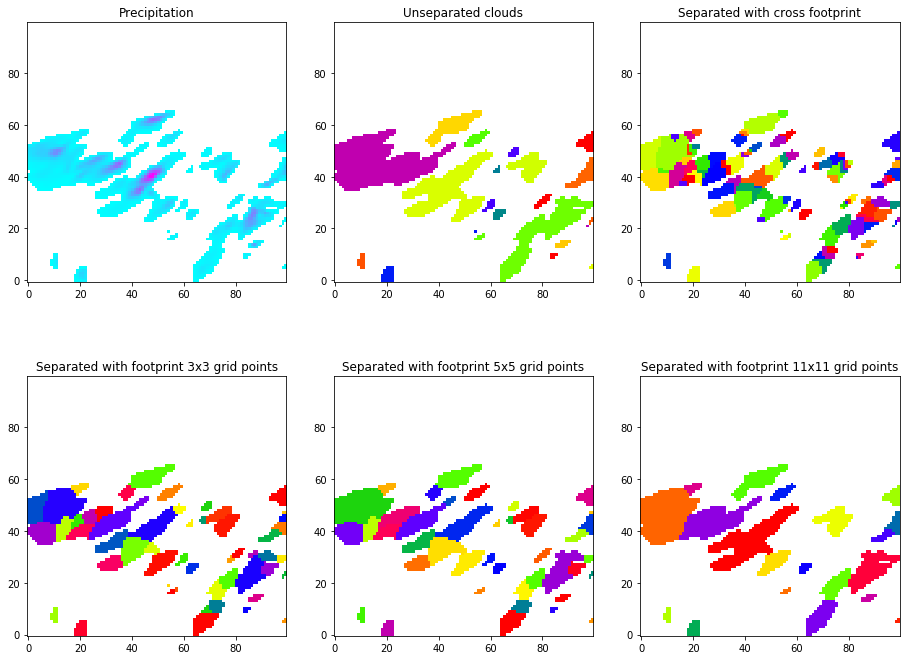

In [15]:
ex_ind = 3   # Pick one example case

plims = (50, 150, 0, 100)   # Chose which section to zoom into for plot

fig, axmat = plt.subplots(2, 3, figsize=(13, 10))
axmat[0, 0].imshow(field_list[ex_ind][plims[0]:plims[1], plims[2]:plims[3]], cmap=cm, origin='lower', vmin = 1)
axmat[0, 0].set_title('Precipitation')
axmat[0, 1].imshow(labels_list[ex_ind][plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prism, origin='lower', vmin = 1)
axmat[0, 1].set_title('Unseparated clouds')

for n, ax in zip([[[0,1,0],[1,1,1],[0,1,0]], 3, 5, 11], np.ravel(axmat)[2:]):
    labels_sep = helpers.identify_clouds(field_list[ex_ind], threshold, water=True, neighborhood = n)[0]
    ax.imshow(labels_sep[plims[0]:plims[1], plims[2]:plims[3]], cmap=cm_prism, origin='lower', vmin = 1)
    if not type(n) is int:
        ax.set_title('Separated with cross footprint')
    else:  
        ax.set_title('Separated with footprint {:d}x{:d} grid points'.format(n, n))
plt.tight_layout()

As we said before the unseparated objects seem too large. Using the smallest footprint (cross), however, results in many very small objects, which doesn't seem to be very realistic. Another issue is that for the larger footprints (11x11) some objects are lost even if they are not connected to other objects. This is due to the minimum distance between the local maxima set by the footprint. 

Feel free to chose any of the other examples. For the scattered cases, the differences are not quite as large. 

For now we choose the 3x3 footprint as a good compromise and explore the sensitivity of the RDF below.

In [16]:
# Do the calculation with a 3x3 footprint for all examples
labels_sep_list = []
for field in field_list:
    labels_sep_list.append(helpers.identify_clouds(field, threshold, water=True, neighborhood=3)[0])

## 2. The Radial Distribution Function

The radial distribution function (RDF) measures the clustering of objects as a function of distance. It is commonly used in statistical mechanics to describe how the density of particles varies as a function of distance from a reference particle. See https://en.wikipedia.org/wiki/Radial_distribution_function

### 2.1 Mathematical formulation
We are computing a discrete version of the RDF in 2D. Each object is defined by its center of mass. 

The normalized RDF $g(r)$ is given by
$$g(r) = \frac{\langle N (r \pm 0.5 \Delta r) \rangle}{A (r \pm 0.5 \Delta r)} \frac{1}{\rho} $$
where $N (r \pm 0.5 \Delta r)$ is the number of objects in the interval $r \pm 0.5 \Delta r$ and the angled brackets indicate the ensemble mean over all objects. $A (r \pm 0.5 \Delta r)$ is the area of the annulus, which is given by $2 \pi r \Delta r$. $\rho$ is the domain mean object density. 

The RDF which is normalized by the domain mean density is therefore unitless and gives the following information: "How much more likely is an object located within a distance interval $[r - \Delta r, r + \Delta r]$ to another object, compared to a completely random distribution of objects in the domain?" A completely random distribution, therefore, has a value of 1 at all radii.

#### Non-normalized version
It can be insightful to also compute the non-normalized version of the RDF, which I will denote here as $n(r) = g(r) * \rho$. This metric then has units [objects per $m^2$] and can be interpreted as: "How many objects per unit area can be found within a distance interval $[r - \Delta r, r + \Delta r]$ to another object?" This metric can be advantageous when comparing RDFs with very different total densities $\rho$, depending on the research question. Note that the shape of the RDF curve remains the same, just the absolute value changes. Therefore the differences will only become apparent when comparing the absolute values of several RDF curves.

In total, we now have 4 different versions of the radial distribution function: separated and non-separated clouds times normalized and non-normalized RDF. Each metric has a slightly different meaning. For our examples, we will now look at all versions.


### 2.2 Computational implementation

The entire calculation including the computation of the centers of mass is done inside the function `helpers.calc_rdf`.

Two parameters have to be specified:

1. The maximum search radius **r_max**
2. The bin size **dr**

#### How to handle boundaries?
There are two boundary situations.

1. Data is available in the entire analysis domain (for example, full model output)
2. Data is available only in part of the domain (for example, radar domain)

In both situations, only identified centers of mass are taken for the RDF computation where the entire circle of radius **r_max** is within the domain where data is available.

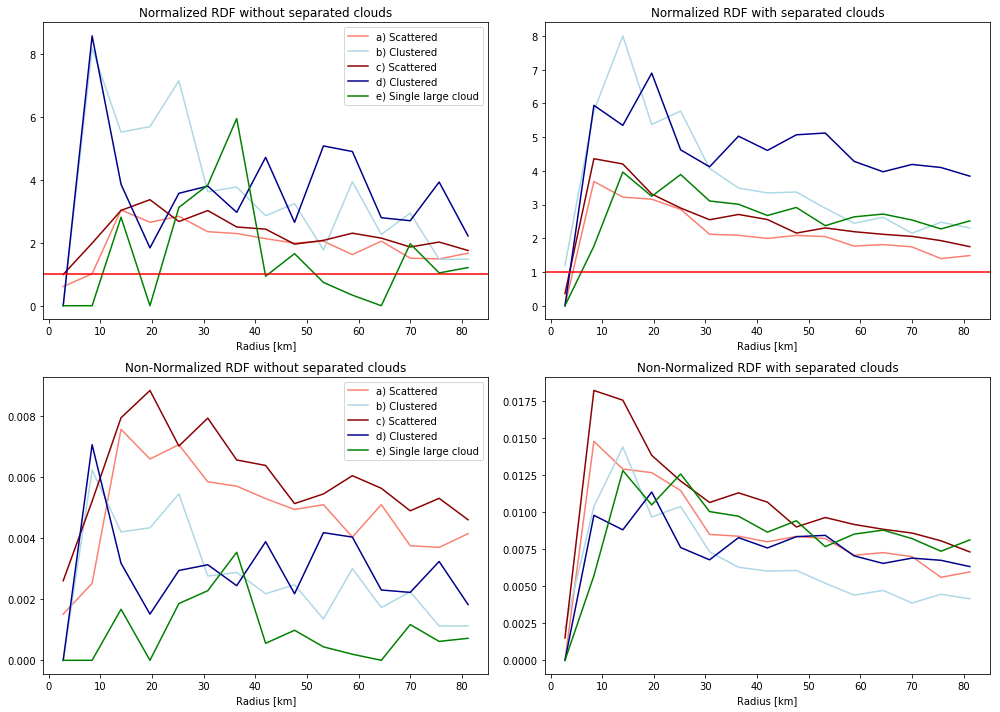

In [20]:
import sys
sys.path.append('../python_scripts')
from helpers import calc_rdf, pair_correlation_2d

r_max = 30   # In grid points
dr = 2       # Also in grid points

fig, axmat = plt.subplots(2, 2, figsize=(14, 10))
colors = ['salmon', 'lightblue', 'darkred', 'darkblue', 'green']   # Only 5 colors because we omit the last example
for labels, labels_sep, field, tag, c in zip(labels_list, labels_sep_list, field_list, tags, colors):
    rdf, radii = calc_rdf(labels, field, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[0, 0].plot(radii / 1000., rdf, label=tag, c=c)
    
    rdf, radii = calc_rdf(labels_sep, field, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[0, 1].plot(radii / 1000., rdf, c=c)
    
    rdf, radii = calc_rdf(labels, field, normalize=False, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[1, 0].plot(radii / 1000., rdf, label=tag, c=c)
    
    rdf, radii = calc_rdf(labels_sep, field, normalize=False, dx=2.8e3, r_max=r_max, dr=dr)
    axmat[1, 1].plot(radii / 1000., rdf, c=c)


axmat[0, 0].set_title('Normalized RDF without separated clouds')
axmat[0, 0].set_xlabel('Radius [km]')
axmat[0, 0].axhline(1, c='r')
axmat[0, 0].legend()

axmat[0, 1].set_title('Normalized RDF with separated clouds')
axmat[0, 1].set_xlabel('Radius [km]')
axmat[0, 1].axhline(1, c='r')

axmat[1, 0].set_title('Non-Normalized RDF without separated clouds')
axmat[1, 0].set_xlabel('Radius [km]')
axmat[1, 0].legend()

axmat[1, 1].set_title('Non-Normalized RDF with separated clouds')
axmat[1, 1].set_xlabel('Radius [km]')

plt.tight_layout()

**Note:** We have igored the f) *hardly any clouds* example because it really gives bizzare results. Simply add a color to the `colors` list to include it again.


### Interpretation

We see that all four versions show different results. Therefore, some interpretation is needed. From our visual interpretation of the scenes, we identified scattered and clustered situations. In the plots above, only the normalized versions show higher values for the clustered scenes. The non-normalized versions have similar or higher values for the scattered scenes. 

Recall that the normalization is done by dividing by the domain-mean object density. Therefore, this metric contains information on the clustering relative to the environment. If we go back to the first plot at the top of the page, it is easy to understand why we get these results. We identified our clustered scenes mainly because there were bigger, isolated blobs of precipitation. In fact, the absolute number of clouds in proximity to other clouds is higher in the scattered cases, simply because the clouds are smaller. This last bit of information is what the non-normalized versions measure. 

Cloud separation for the normalized versions does not seem to change the results too much qualitatively for the two scattered and clustered examples.

A complicated case is the *single large cloud* example. With cloud separation the RDF looks similar to the scattered cases. Without cloud separation the RDF has a distinct peak at larger values. 

We therefore come to the following comclusions for our examples:
- The normalized versions come closest to our visual interpretation
- Separated versus unseparated RDFs shows qualitatively similar results except for
- *Single large cloud* example shows strange behavior. This could indicate that the RDF is designed to detect one specific type of organization: clustering. Other forms of organization (often caused by synoptic processes in the atmosphere) are hard to interpret with the measure.

### 2.3 Sensitivity to Footprint

Lastly, we want to test the sensitivity of the RDF to the **footprint** parameter.

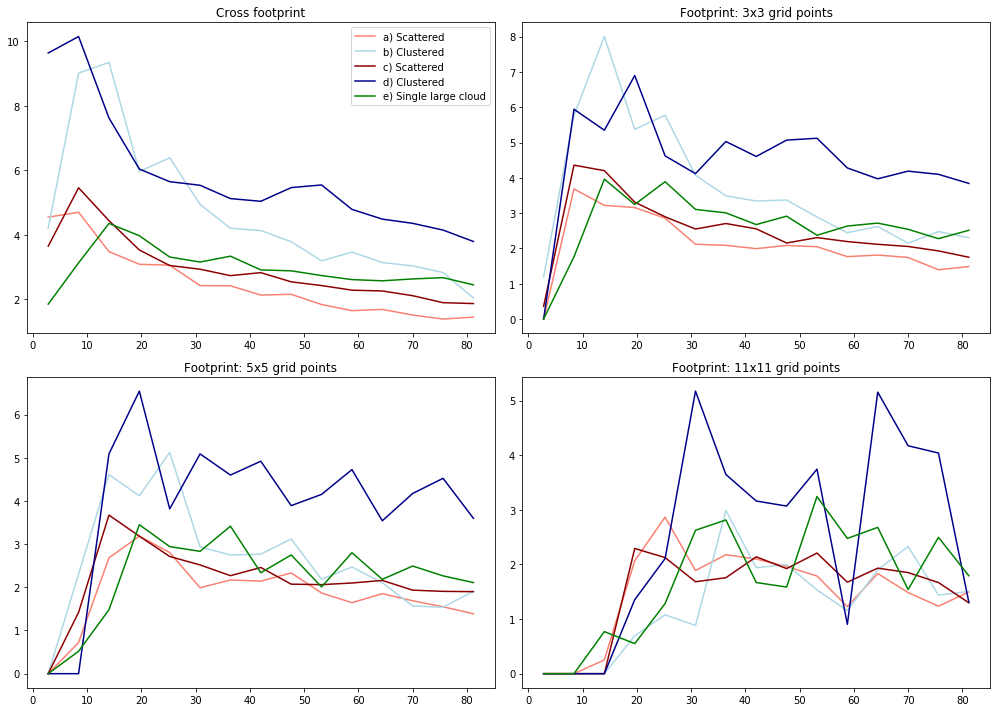

In [21]:
fig, axmat = plt.subplots(2, 2, figsize=(14, 10))
for n, ax in zip([[[0,1,0],[1,1,1],[0,1,0]], 3, 5, 11], np.ravel(axmat)):
    for field, tag, c in zip(field_list, tags, colors):
        labels_sep = helpers.identify_clouds(field, threshold, water=True, neighborhood = n)[0]
        rdf, radii = calc_rdf(labels_sep, field, normalize=True, dx=2.8e3, r_max=r_max, dr=dr)
        ax.plot(radii / 1000., rdf, label=tag, c=c)
    if not type(n) is int:
        ax.set_title('Cross footprint')
    else:  
        ax.set_title('Footprint: {:d}x{:d} grid points'.format(n, n))
axmat[0, 0].legend()
plt.tight_layout()

Here we see that the cross, 3x3 and 5x5 give qualitatively similar results. Only the largest (11x11) footprint shows strange results. This means that the exact choice of parameter for the cloud separation is not too important for the examples chosen here. 

### 2.4 Converting the RDF curves to a single number

To illustrate the time change in clustering, it can be desirable to convert the RDF curve to a single number. Since the shape of the curves does not differ too much, the simplest option (the one we chose for our study as well) is simply to take the maximum value. 

## 3. Conclusion

Hopfully this notebook serves as a useful example for identifying cloud objects and quantifying cloud clustering. We think it is important to note that there is no single "one-size-fits-all" measure for cloud organization. A cloud organization parameter has to be designed with a specific application in mind. 

The RDF measures the clustering of small convective cells, but does not seem to know what to do with larger precipitation fields in strong synoptic forcing. 

Finally, we are greatful for any comments on this notebook.